# Predict Ethereum Close Price

* https://www.crosstab.io/articles/time-series-pytorch-lstm
* https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

import torch
from torch.nn import BCELoss
from torch.utils.data import DataLoader

import pytorch_common.util    as pu
from   pytorch_common.util import set_device_name, \
                                  get_device, \
                                  LoggerBuilder

from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel

from data   import SequenceDataset, \
                   standarizer, \
                   variable_to_sequences, \
                   features_target_split, \
                   train_test_split
from util   import set_seed, \
                   loss_wrapper
from module import TimeSeriesPredictor

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
pu.set_device_name('gpu')

In [6]:
pu.get_device()

device(type='cuda', index=0)

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.11.0'

In [9]:
sns.set(rc = {'figure.figsize':(15,8)})

In [10]:
set_seed(42)

In [11]:
WINDOW_SIZE = 60
N_WORKERS   = 24
BATCH_SIZE  = 512
VARIABLE    = 'close'
TRAIN       = False

In [12]:
DATASET_PATH = '../datasets/ETH_1H.csv'
WEIGHTS_PATH = '../weights'

## Preprocessing

#### 1. Load dataset.

In [13]:
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.lower()
df.columns

Index(['unix timestamp', 'date', 'symbol', 'open', 'high', 'low', 'close',
       'volume'],
      dtype='object')

In [14]:
dataset = df[['date', VARIABLE]]
dataset.head()

,date,close
0,2020-04-16 00:00:00,150.39
1,2020-04-15 23:00:00,152.94
2,2020-04-15 22:00:00,155.81
3,2020-04-15 21:00:00,157.18
4,2020-04-15 20:00:00,158.04


In [15]:
dataset.shape

(34497, 2)

#### 2. Train-test splot and normalize data:

In [16]:
train_set,      test_set      = train_test_split(dataset, test_percent = 0.3)
norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=[VARIABLE])

train_set.shape, test_set.shape

((24149, 2), (10349, 2))

In [17]:
norm_train_set.head()

,date,close,norm_close
0,2020-04-16 00:00:00,150.39,-0.718088
1,2020-04-15 23:00:00,152.94,-0.707273
2,2020-04-15 22:00:00,155.81,-0.695102
3,2020-04-15 21:00:00,157.18,-0.689292
4,2020-04-15 20:00:00,158.04,-0.685645


#### 3. Separare into sequences using a sliding window.

In [35]:
variable_norm_values = norm_train_set[f'norm_{VARIABLE}']

train_set_sequences = variable_to_sequences(variable_norm_values, WINDOW_SIZE)
test_set_sequences  = variable_to_sequences(variable_norm_values,  WINDOW_SIZE)

train_set_sequences.shape, test_set_sequences.shape

((24090, 60), (24090, 60))

#### 4. Separate sequences into (features=sequence-1, target=last):

In [19]:
train_features, train_targets = features_target_split(train_set_sequences)
test_features,  test_targets  = features_target_split(test_set_sequences)

train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((24090, 59), (24090,), (10290, 59), (10290,))

In [20]:
torch.tensor(train_features).unsqueeze(2).float().shape

torch.Size([24090, 59, 1])

#### 5. Create a dataset for both train an test sets:

In [21]:
train_dataset = SequenceDataset(train_features, train_targets)
test_dataset  = SequenceDataset(test_features, test_targets)

len(train_dataset), len(test_dataset)

(24090, 10290)

In [22]:
f, t = train_dataset[0]
f.shape, t.shape

(torch.Size([59, 1]), torch.Size([]))

In [23]:
f, t = test_dataset[0]
f.shape, t.shape

(torch.Size([59, 1]), torch.Size([]))

#### 6. Create datalodesd for both tra and test datasets:

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

f, t = next(iter(train_loader))
f.shape, t.shape

(torch.Size([512, 59, 1]), torch.Size([512]))

In [25]:
f, t = next(iter(test_loader))
f.shape, t.shape

(torch.Size([512, 59, 1]), torch.Size([512]))

# Model Definition

In [26]:
learning_rate  = 0.001
n_hidden_units = 1024
sequence_size  = WINDOW_SIZE -1
n_epochs       = 30
n_layers       = 5
dropout        = 0.1
total_samples  = len(train_dataset)


model = TimeSeriesPredictor(
    input_size     = 1, 
    n_hidden_units = n_hidden_units, 
    n_layers       = n_layers,
    dropout        = dropout
).to(pu.get_device())

model

TimeSeriesPredictor(
  (rnn): GRU(1, 1024, num_layers=5, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=1024, out_features=1, bias=True)
)

In [27]:
f, t = next(iter(test_loader))
f.shape, model(f).shape

(torch.Size([512, 59, 1]), torch.Size([512]))

# Train

In [28]:
if TRAIN:
    loss_fn = nn.MSELoss()

    model.fit(
        train_loader,
        loss_fn   = loss_fn,
        epochs    = n_epochs,
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr = learning_rate
        ),
        callbacks   = [
            Validation(
                test_loader,
                metrics       = { 'val_loss': loss_wrapper(loss_fn) },
                each_n_epochs = 1
            ),
            Logger(['time', 'epoch', 'train_loss', 'val_loss']),
            MetricsPlotter(metrics=['train_loss', 'val_loss']),
            SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='lstm-time-series')
        ]
    )

# Validation

In [29]:
def plot_train_set(y_pred, y_true, times):
    sns.set_style("darkgrid")
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.plot(y_true[:times], color='green',label="Truth")
    plt.legend()
    plt.show()

# Predictions

In [30]:
PATH = f'{WEIGHTS_PATH}/2022-08-12_17-42-45--lstm-time-series--epoch_18--val_loss_0.0001459738559788093.pt'

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

<Figure size 1080x576 with 1 Axes>

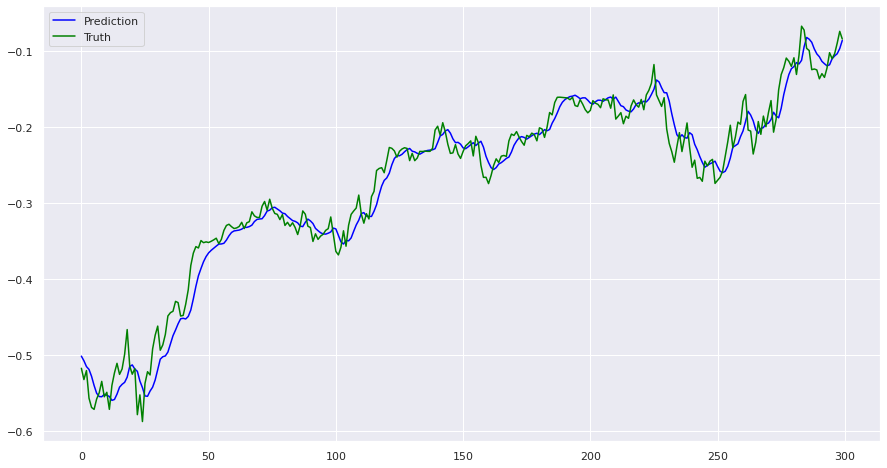

In [37]:
y_pred, y_true = model.validation(test_loader)

plot_train_set(y_pred, y_true, times=300)

# Interpolation